In [156]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
dy_name = 'snv_indel_eqtl_properties'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

import gc

import scipy.stats as sps
import vapeplot

In [285]:
dy_name = 'Figures'

figures_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(figures_out):
    cpy.makedir(figures_out)

In [15]:
def prep_per_var(per_var, var_egene_nr):
    coding_egenes = var_egene_nr[(var_egene_nr.coding == True) & 
                                 (var_egene_nr.significant)].groupby('NR_ID').feature_id.unique().apply(len)

    ncoding_egenes = var_egene_nr[(var_egene_nr.coding == False) & 
                                  (var_egene_nr.significant)].groupby('NR_ID').feature_id.unique().apply(len)

    coding_tested = var_egene_nr[(var_egene_nr.coding == True)].groupby('NR_ID').feature_id.unique().apply(len)
    ncoding_tested = var_egene_nr[(var_egene_nr.coding == False)].groupby('NR_ID').feature_id.unique().apply(len)

    coding_lead = var_egene_nr[(var_egene_nr.coding == True) & 
                               (var_egene_nr.top_hit_final_sig)].groupby('NR_ID').feature_id.unique().apply(len)
    ncoding_lead = var_egene_nr[(var_egene_nr.coding == False) & 
                                (var_egene_nr.top_hit_final_sig)].groupby('NR_ID').feature_id.unique().apply(len)

    # coding_tested = var_egene_nr[(var_egene_nr.coding == True)].groupby('NR_ID').feature_id.unique().apply(len)
    # ncoding_tested = var_egene_nr[(var_egene_nr.coding == False)].groupby('NR_ID').feature_id.unique().apply(len)

    per_var['num_coding_egenes_lead'] = coding_lead
    per_var['num_noncoding_egenes_lead'] = ncoding_lead

    var_egene_nr = var_egene[(var_egene.most_significant_nr)]

    per_var['num_coding_egenes'] = coding_egenes
    per_var['num_noncoding_egenes'] = ncoding_egenes

    per_var['num_coding_tested'] = coding_tested
    per_var['num_noncoding_tested'] = ncoding_tested

    per_var = per_var.fillna(0)
    return per_var

In [184]:
def add_svtype_cats(all_qtls_filt, col = 'SVTYPE_NR'):
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'SNV': 'SNV', 'INDEL_DEL': 'INDEL', 
               'INDEL_INS': 'INDEL'}
    all_qtls_filt['SVTYPE_SUPER'] = all_qtls_filt[col].apply(lambda x: convert.get(x, 'SV'))
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'MEI', 
               'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV', 'SNV': 'SNV', 
               'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
               'INDEL': 'INDEL', 'SNP': "SNV"}
    
    all_qtls_filt['SVTYPE_COLLAPSE'] = all_qtls_filt[col].apply(lambda x: convert.get(x, 'other SV'))
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI', 'SNV': 'SNV', 
               'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
               'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_NR_C'] = all_qtls_filt[col].apply(lambda x: convert.get(x,x))
    return all_qtls_filt

In [16]:
def as_si(x, ndp, e_fmt = False):
        s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
        if e_fmt:
            out = s
        else:
            m, e = s.split('e')
            out = r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
        return out

In [58]:
def add_fraction_contingency(df):
    df = df.copy()
    df['fraction'] = df['contingency'].apply(lambda x: x[0][0]/ sum(x[0]))
    return df

In [59]:
def vc_w_prop(df, gb_col, bool_col):
    vc = df.groupby(gb_col)[bool_col].value_counts().to_frame('count')
    vc_frac = df.groupby(gb_col)[bool_col].value_counts(normalize = True).to_frame('fraction')
    vc = vc.join(vc_frac)
    vc = vc.reset_index()
    tot = vc.groupby(gb_col)['count'].sum().to_frame('total')
    
    vc = vc[vc[bool_col] == True] 
    
    vc = vc.set_index(gb_col).join(tot)
    vc = vc.reset_index()
    return vc

In [65]:
def vc_unique_add_proportion(df, gb, col_unique):
    """groupby two categories, and count the number of unique elements in the third
    and proportion of total unique elements"""
    vc = df.groupby((gb[0], gb[1]))[col_unique].apply(lambda x: len(set(x))).to_frame('count').reset_index()
    vc_tot = df.groupby(gb[0])[col_unique].apply(lambda x: len(set(x))).to_frame('total')
    vc = vc[vc[gb[1]] == True]
    vc = vc.set_index(gb[0])
    vc = vc.join(vc_tot)
    vc['fraction'] = vc['count'] / vc['total']
    return vc

def add_fraction(vc, col, col_bool, count_col = 'count'):
    vc_tot = vc.groupby(col)[count_col].sum().to_frame('total')
    vc = vc[vc[col_bool] == True]
    vc = vc.set_index(col)
    vc = vc.join(vc_tot)
    vc['fraction'] = vc['count'] / vc['total']
    return vc

def vc_w_prop(df, gb_col, bool_col):
    vc = df.groupby(gb_col)[bool_col].value_counts().to_frame('count')
    vc_frac = df.groupby(gb_col)[bool_col].value_counts(normalize = True).to_frame('fraction')
    vc = vc.join(vc_frac)
    vc = vc.reset_index()
    tot = vc.groupby(gb_col)['count'].sum().to_frame('total')
    
    vc = vc[vc[bool_col] == True] 
    
    vc = vc.set_index(gb_col).join(tot)
    vc = vc.reset_index()
    return vc

In [118]:
def extract_per_variant_df(var_egene_in):
    
    var_egene = var_egene_in[var_egene_in.most_significant_nr]
    th = var_egene[var_egene.top_hit==True]
    nr_ids = var_egene.NR_ID.unique().tolist()
    sig_assoc = var_egene.NR_ID.unique().tolist()
    th_assoc = th.NR_ID.unique().tolist()
    
    per_var_info = pd.DataFrame(index = nr_ids)
    per_var_info['significant_association'] = per_var_info.index.isin(sig_assoc)
    per_var_info['lead_association'] = per_var_info.index.isin(th_assoc)
    
    
    num_egenes_total = (var_egene.groupby('NR_ID').feature_id.apply(lambda x: len(set(x))))
    num_egenes_th = (th.groupby('NR_ID').feature_id.apply(lambda x: len(set(x))))
#     num_genes_tested = var_egene.groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x)))
#     thresh = 10000
    
    per_var_info = per_var_info.join(num_egenes_total.to_frame('num_egenes'))
    per_var_info = per_var_info.join(num_egenes_th.to_frame('num_egenes_lead'))

    per_var_info['ALL_VARS'] = 'ALL_VARS'
    per_var_info['NR_ID'] = per_var_info.index
    
    info_nr = sig_joint.drop_duplicates(['NR_ID'])[['NR_ID','SVTYPE_NR', 'VARIANT_TYPE', 
                                                    'VARIANT_TYPE_NR']]
    info_nr = info_nr.set_index('NR_ID')
    per_var_info = per_var_info.join(info_nr)

    
    return per_var_info

In [79]:
def tag_most_sig_per_cluster_per_gene(all_qtls):
#     all_qtls['NR_ID_tested'] = (all_qtls.snp_id == all_qtls.Non_Redundant_ID)
    
    all_qtls = all_qtls.sort_values(['feature_id', 'NR_ID', 'empirical_feature_p_value'])
    all_qtls = all_qtls.set_index('gene_var_id', drop = False)
    t = all_qtls.drop_duplicates(['NR_ID', 'feature_id'], keep = 'first')
    inds = t.index.tolist()
    all_qtls['most_significant_nr'] = False
    all_qtls.loc[inds, 'most_significant_nr'] = True
    return all_qtls

# Joint Prep

In [80]:
sig_joint = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing_joint/qtl_results_01_19/sig_joint_story5_annot_v2.pkl').pipe(tag_most_sig_per_cluster_per_gene)

In [198]:
sig_joint['exonic'] = sig_joint.genic_category_variant.isin(['contains_gene', 
                                                   'contains_exon', 'intersects_exon'])
sig_joint['dist_from_gene_250kb'] = (sig_joint.gene_dist_abs > 250000)
sig_joint['gene_dist_abs'] = sig_joint.gene_distance.abs()
sig_joint['beta_abs'] = sig_joint.beta.abs()
sig_joint = sig_joint.pipe(add_svtype_cats)
th_joint = sig_joint[sig_joint.top_hit] # top hits including ties

In [293]:
CM.save_dataframe('sig_joint_annot_prop', sig_joint, private_out)

sig_joint_annot_prop = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/sig_joint_annot_prop.pkl')
sig_joint_annot_prop = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/sig_joint_annot_prop.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/load_pickled_nb_variables.py


In [119]:
per_var_joint = extract_per_variant_df(sig_joint)
per_var_joint = per_var_joint.pipe(add_svtype_cats, 'VARIANT_TYPE_NR')

In [294]:
CM.save_dataframe('per_var_joint', per_var_joint, private_out)

per_var_joint = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/per_var_joint.pkl')
per_var_joint = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/per_var_joint.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/snv_indel_eqtl_properties/load_pickled_nb_variables.py


In [69]:
frac_250kb_snv_indel = vc_w_prop(sig_joint, 'VARIANT_TYPE', 'dist_from_gene_250kb')
frac_250kb_snv_indel_th = vc_w_prop(th_joint, 'VARIANT_TYPE', 'dist_from_gene_250kb')
frac_250kb_snv_indel = frac_250kb_snv_indel.set_index('VARIANT_TYPE', drop = False)
frac_250kb_snv_indel_th = frac_250kb_snv_indel_th.set_index('VARIANT_TYPE', drop = False)

In [98]:
sig_joint.VARIANT_TYPE.unique()

array(['SNV', 'INDEL', 'STR', 'rMEI', 'ALU', 'DEL', 'DUP', 'BND', 'mCNV',
       'LINE1', 'SVA', 'INV'], dtype=object)

# Bubble Plot Joint

In [104]:
def lambda_cap_group(x, thresh = 2, how = 'greater', alternate = False):
    if how =='greater':
        if x >= thresh:
            if alternate:
                return alternate
            else:
                return thresh
            
    if how == 'less':
        if x <= thresh:
            if althernate:
                return alternate
            else:
                return thresh
            
    return x

In [102]:
def bubble_prep_joint(per_var):
    per_var['cap_num_egenes_lead'] = per_var.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4))
    per_var['label_num_egenes_lead'] =  per_var.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4, 
                                                                                                 alternate='4+'))

    per_var['cap_num_egenes'] = per_var.num_egenes.apply(lambda x: lambda_cap_group(x, 4))
    per_var['label_num_egenes'] =  per_var.num_egenes.apply(lambda x: lambda_cap_group(x, 4, alternate='4+'))

    a =per_var[(per_var.num_egenes_lead > 0)].groupby('VARIANT_TYPE').cap_num_egenes_lead.value_counts(normalize = True).to_frame('frac_ev')

    b = per_var[(per_var.num_egenes_lead > 0)].groupby('VARIANT_TYPE').cap_num_egenes_lead.value_counts(normalize = False).to_frame('num_ev')
    fpc = a.join(b).reset_index()
    fpc['label'] = fpc.cap_num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4, alternate='4+'))

    # fp =per_var[(per_var.num_egenes_lead > 0)].groupby('SVTYPE_NR_C').num_egenes_lead.value_counts(normalize = True).to_frame('num_ev').reset_index()
    # fp['cap_n_egenes'] = fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4))
    # fp['label_n_egenes'] =  fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, '4+'))
    sizes = np.log10(fpc.frac_ev + 1) * 100
    fpc['sizes'] = sizes

    sb = pd.pivot_table(fpc, columns='VARIANT_TYPE', index = 'cap_num_egenes_lead', values = 'frac_ev')
    rank = dict(zip(order_vars_c, range(0, len(order_vars_c))))
    sb2 = pd.pivot_table(fpc, columns='VARIANT_TYPE', index = 'cap_num_egenes_lead', values = 'num_ev')
    fpc['SVTYPE_rank'] = fpc.VARIANT_TYPE.map(rank)
    fpc['SVTYPE_rank_plot'] = fpc.SVTYPE_rank + 0.5
    fpc['egenes_plot'] = fpc.cap_num_egenes_lead - 0.5
    # sns.scatterplot(x = 'cap_num_egenes_lead', y = 'frac_ev', hue = 'SVTYPE_NR_C', 
    #                 size = 'frac_ev', data = fpc, sizes = (20, 200))

    a =per_var[(per_var.num_egenes > 0)].groupby('VARIANT_TYPE').cap_num_egenes.value_counts(normalize = True).to_frame('frac_ev')

    b = per_var[(per_var.num_egenes > 0)].groupby('VARIANT_TYPE').cap_num_egenes.value_counts(normalize = False).to_frame('num_ev')
    fpc = a.join(b).reset_index()
    fpc['label'] = fpc.cap_num_egenes.apply(lambda x: lambda_cap_group(x, 4, alternate='4+'))

    # fp =per_var[(per_var.num_egenes_lead > 0)].groupby('SVTYPE_NR_C').num_egenes_lead.value_counts(normalize = True).to_frame('num_ev').reset_index()
    # fp['cap_n_egenes'] = fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4))
    # fp['label_n_egenes'] =  fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, '4+'))
    sizes = np.log10(fpc.frac_ev + 1) * 100
    fpc['sizes'] = sizes

    sb = pd.pivot_table(fpc, columns='VARIANT_TYPE', index = 'cap_num_egenes', values = 'frac_ev')
    rank = dict(zip(order_vars_c, list(reversed(range(0, len(order_vars_c))))))
    sb2 = pd.pivot_table(fpc, columns='VARIANT_TYPE', index = 'cap_num_egenes', values = 'num_ev')
    fpc['SVTYPE_rank'] = fpc.VARIANT_TYPE.map(rank)
    fpc['SVTYPE_rank_plot'] = fpc.SVTYPE_rank + 0.5
    fpc['egenes_plot'] = fpc.cap_num_egenes - 0.5
    # sns.scatterplot(x = 'cap_num_egenes_lead', y = 'fra

#     sb3 = sb2.copy()
#     sb3 = sb3.applymap(lambda x: np.NaN)
#     sb2 = sb2.T.loc[order_vars_c]
#     sb3 = sb3.T.loc[order_vars_c]
#     sb3 = sb3.fillna(0)
#     sb2 = sb2.fillna(0)
#     sb2 = sb2.applymap(int)
#     sb = sb.T.loc[order_vars_c]
    
    return fpc

In [158]:
order_vars_c_all = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'MEI', 'BND','STR', 'INDEL','SNV']


In [121]:
fpc_joint = bubble_prep_joint(per_var_joint)

In [123]:
fpc_joint_plot = fpc_joint[fpc_joint.VARIANT_TYPE.isin(['SNV', 'INDEL'])]

# Data from SV only

In [12]:
var_egene = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/var_egene_annot_maf5_sv_only.pkl')
var_egene['beta_abs'] = var_egene.beta.abs()

var_egene_nr = var_egene[var_egene.most_significant_nr == True]

inds = var_egene_nr[(var_egene_nr.SVTYPE_NR == 'DEL') & (var_egene_nr.CALLER == 'GS')].index.tolist()
var_egene_nr.loc[inds, 'beta_corrected'] = var_egene_nr.loc[inds, 'beta']  * -1
var_egene_nr['exonic'] =  var_egene_nr.coding # make naming better

In [18]:
per_var = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/per_variant_info_sv_only.pkl').pipe(prep_per_var, var_egene_nr)

per_var = per_var.pipe(add_svtype_cats)

In [ ]:
per_var['VARIANT_TYPE'] = per_var.SVTYPE
per_var['VARIANT_TYPE_NR'] = per_var.SVTYPE_NR

In [48]:
frac_svtype_th = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/frac_svtype_th.pkl')
frac_svtype_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/frac_svtype_all.pkl')

df_plot = frac_svtype_all.merge(frac_svtype_th, on = 'SVTYPE_NR_C', suffixes=('_sig', '_lead'))
df_plot = df_plot.set_index('SVTYPE_NR_C').loc[order_vars_c][['fraction_sig', 'fraction_lead']]

In [49]:
frac_250kb_qtl_th = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/frac_250kb_qtl_th.pkl').set_index('SVTYPE_NR_C')
frac_250kb_qtl_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/frac_250kb_qtl_all.pkl').set_index('SVTYPE_NR_C')
frac_250kb_qtl_th.loc['INV', 'fraction'] = 0.0
frac_250kb_qtl_th.loc['INV', 'SVTYPE_NR_C'] = 'INV'

In [192]:
enr_svt_genic_cat_lead_prop = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/enr_svt_genic_cat_lead_prop.pkl').pipe(add_fraction_contingency)

In [277]:
enr_svtypes_th_c = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/enr_svtypes_th_c.pkl')
enr_svtypes_nr_c = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/enr_svtypes_nr_c.pkl')
enr_svtypes_nr_c['category'] = 'significant'
enr_svtypes_th_c['category'] = 'lead'
enr_svtypes_all = pd.concat([enr_svtypes_nr_c, enr_svtypes_th_c])

In [ ]:
# frac_svtype_th = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/frac_svtype_th.pkl')
# frac_svtype_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v2/frac_svtype_all.pkl')

# df_plot = frac_svtype_all.merge(frac_svtype_th, on = 'SVTYPE_NR_C', suffixes=('_sig', '_lead'))
# df_plot = df_plot.set_index('SVTYPE_NR_C').loc[order_vars_c][['fraction_sig', 'fraction_lead']]

# Bubble SV-only

In [133]:
def bubble_prep_sv_only(per_var):
    per_var['cap_num_egenes_lead'] = per_var.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4))
    per_var['label_num_egenes_lead'] =  per_var.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4, 
                                                                                                 alternate='4+'))

    per_var['cap_num_egenes'] = per_var.num_egenes.apply(lambda x: lambda_cap_group(x, 4))
    per_var['label_num_egenes'] =  per_var.num_egenes.apply(lambda x: lambda_cap_group(x, 4, alternate='4+'))

    a =per_var[(per_var.num_egenes_lead > 0)].groupby('SVTYPE_NR_C').cap_num_egenes_lead.value_counts(normalize = True).to_frame('frac_ev')

    b = per_var[(per_var.num_egenes_lead > 0)].groupby('SVTYPE_NR_C').cap_num_egenes_lead.value_counts(normalize = False).to_frame('num_ev')
    fpc = a.join(b).reset_index()
    fpc['label'] = fpc.cap_num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4, alternate='4+'))

    # fp =per_var[(per_var.num_egenes_lead > 0)].groupby('SVTYPE_NR_C').num_egenes_lead.value_counts(normalize = True).to_frame('num_ev').reset_index()
    # fp['cap_n_egenes'] = fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4))
    # fp['label_n_egenes'] =  fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, '4+'))
    sizes = np.log10(fpc.frac_ev + 1) * 100
    fpc['sizes'] = sizes

    sb = pd.pivot_table(fpc, columns='SVTYPE_NR_C', index = 'cap_num_egenes_lead', values = 'frac_ev')
    rank = dict(zip(order_vars_c, range(0, len(order_vars_c))))
    sb2 = pd.pivot_table(fpc, columns='SVTYPE_NR_C', index = 'cap_num_egenes_lead', values = 'num_ev')
    fpc['SVTYPE_rank'] = fpc.SVTYPE_NR_C.map(rank)
    fpc['SVTYPE_rank_plot'] = fpc.SVTYPE_rank + 0.5
    fpc['egenes_plot'] = fpc.cap_num_egenes_lead - 0.5
    # sns.scatterplot(x = 'cap_num_egenes_lead', y = 'frac_ev', hue = 'SVTYPE_NR_C', 
    #                 size = 'frac_ev', data = fpc, sizes = (20, 200))

    a =per_var[(per_var.num_egenes > 0)].groupby('SVTYPE_NR_C').cap_num_egenes.value_counts(normalize = True).to_frame('frac_ev')

    b = per_var[(per_var.num_egenes > 0)].groupby('SVTYPE_NR_C').cap_num_egenes.value_counts(normalize = False).to_frame('num_ev')
    fpc = a.join(b).reset_index()
    fpc['label'] = fpc.cap_num_egenes.apply(lambda x: lambda_cap_group(x, 4, alternate='4+'))

    # fp =per_var[(per_var.num_egenes_lead > 0)].groupby('SVTYPE_NR_C').num_egenes_lead.value_counts(normalize = True).to_frame('num_ev').reset_index()
    # fp['cap_n_egenes'] = fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, 4))
    # fp['label_n_egenes'] =  fp.num_egenes_lead.apply(lambda x: lambda_cap_group(x, '4+'))
    sizes = np.log10(fpc.frac_ev + 1) * 100
    fpc['sizes'] = sizes

    sb = pd.pivot_table(fpc, columns='SVTYPE_NR_C', index = 'cap_num_egenes', values = 'frac_ev')
    rank = dict(zip(order_vars_c, list(reversed(range(0, len(order_vars_c))))))
    sb2 = pd.pivot_table(fpc, columns='SVTYPE_NR_C', index = 'cap_num_egenes', values = 'num_ev')
    fpc['SVTYPE_rank'] = fpc.SVTYPE_NR_C.map(rank)
    fpc['SVTYPE_rank_plot'] = fpc.SVTYPE_rank + 0.5
    fpc['egenes_plot'] = fpc.cap_num_egenes - 0.5
    
    return fpc

In [135]:
fpc_sv_only = bubble_prep_sv_only(per_var)

# Combine the data from joint and SV_Only (for plotting)

In [139]:
fpc_sv_only['VARIANT_TYPE'] = fpc_sv_only.SVTYPE_NR_C
fpc_joint_plot['SVTYPE_NR_C'] = fpc_joint_plot.VARIANT_TYPE

In [142]:
fpc_all_plot = pd.concat([fpc_joint_plot, fpc_sv_only])

In [151]:
per_var_joint_plot = per_var_joint[per_var_joint.VARIANT_TYPE.isin(['INDEL', 'SNV'])]

In [152]:
per_var_combined = pd.concat([per_var, per_var_joint_plot])

# Stacked Bar of eQTL localization of Leads- adding in joint

In [185]:
th_joint = th_joint.pipe(add_svtype_cats)

In [182]:
th_joint.SVTYPE_NR_C.value_counts()

SNV          8305
INDEL_DEL    1513
INDEL_INS    1222
STR           171
mCNV          114
DEL            55
MEI            15
DUP             9
BND             8
rMEI            3
Name: SVTYPE_NR_C, dtype: int64

In [186]:

a = th_joint.groupby('SVTYPE_NR_C').genic_category_collapsed.value_counts(normalize = True).to_frame('fraction')
b = th_joint.groupby('SVTYPE_NR_C').genic_category_collapsed.value_counts(normalize = False).to_frame('count')
summary_lead_gen_cat_joint = a.join(b).reset_index()
sb_gen_cat_joint = pd.pivot_table(summary_lead_gen_cat_joint, 
                            index = 'SVTYPE_NR_C', columns = 'genic_category_collapsed',
                            values='fraction').fillna(0)

In [177]:
a = var_egene_nr[var_egene_nr.top_hit_final_sig].groupby('SVTYPE_NR_C').genic_category_collapsed.value_counts(normalize = True).to_frame('fraction')
b = var_egene_nr[var_egene_nr.top_hit_final_sig].groupby('SVTYPE_NR_C').genic_category_collapsed.value_counts(normalize = False).to_frame('count')
summary_lead_gen_cat = a.join(b).reset_index()
sb_gen_cat = pd.pivot_table(summary_lead_gen_cat, 
                            index = 'SVTYPE_NR_C', columns = 'genic_category_collapsed',
                            values='fraction').fillna(0)

In [189]:
sb_gen_cat_plot = pd.concat([sb_gen_cat, sb_gen_cat_joint.loc[['INDEL', 'SNV']]])

In [217]:
th_joint_merge = th_joint[th_joint.VARIANT_TYPE.isin(['SNV', 'INDEL'])]
th_joint_merge['beta_corrected'] = th_joint_merge['beta'].astype(float)

In [218]:
th_all = pd.concat([var_egene_nr[var_egene_nr.top_hit_final_sig], 
                    th_joint_merge])

# Stats

In [42]:
def compute_mannu_vs_str(df, col):
#     df = df[df.significant]
    obs = df[df.SVTYPE_NR_C == 'STR'][col].tolist()
    data = []
    for i in order_vars_c:
        comp = df[df.SVTYPE_NR_C == i][col].tolist()
    #     obs = df[df.SVTYPE_NR_C != i].num_egenes_lead.tolist()
        mu, p = sps.mannwhitneyu(comp, obs)
        mean_c = np.mean(comp)
        t, p_t = sps.ttest_ind(comp, obs)
        data.append([mu, p, i, mean_c, t, p_t, col])
    stats = pd.DataFrame(data, columns = ['mu', 'p_value', 'SVTYPE_NR_C', 'mean_c', 'T', 'p_value_t',
                                          "variable"])
    stats['p_bonf'] = stats['p_value'] * (stats.shape[0] -1)
    stats['p_bonf_t'] = stats['p_value_t'] * (stats.shape[0] -1)
    stats = stats.set_index('SVTYPE_NR_C', drop = False)
    return stats

In [45]:
var_egene_nr['gene_distance_abs'] = var_egene_nr.gene_distance.abs()
stats_gd_sig = compute_mannu_vs_str(var_egene_nr[var_egene_nr.significant], 'gene_distance_abs')
stats_gd_lead = compute_mannu_vs_str(var_egene_nr[var_egene_nr.top_hit_final_sig], 'gene_distance_abs')

In [46]:
stats_es_svt_ne =  compute_mannu_vs_str(per_var[per_var.num_egenes > 0], 'num_egenes')

In [251]:
data = []
top = var_egene_nr[(var_egene_nr.top_hit_final_sig) & (var_egene_nr.coding)]
svt = 'mCNV'
obs = top[top.SVTYPE_NR_C == 'mCNV'].beta_abs

comp = top[top.SVTYPE_NR_C == 'STR'].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'STR', 'exonic'])

comp = top[~(top.SVTYPE_NR_C.isin(['STR', svt]))].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'SV', 'exonic'])

comp = th_joint[(th_joint.VARIANT_TYPE.isin(['SNV'])) & (th_joint.exonic)].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'SNV', 'exonic'])

comp = th_joint[(th_joint.VARIANT_TYPE.isin(['INDEL'])) & (th_joint.exonic)].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'INDEL', 'exonic'])



top = var_egene_nr[(var_egene_nr.top_hit_final_sig) & (var_egene_nr.coding==False)]
obs = top[top.SVTYPE_NR_C == 'mCNV'].beta_abs

comp = top[top.SVTYPE_NR_C == 'STR'].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'STR', 'non-exonic'])

comp = top[~(top.SVTYPE_NR_C.isin(['STR', svt]))].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'SV', 'non-exonic'])

comp = th_joint[(th_joint.VARIANT_TYPE.isin(['SNV'])) & (th_joint.exonic == False)].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'SNV', 'non-exonic'])

comp = th_joint[(th_joint.VARIANT_TYPE.isin(['INDEL'])) & (th_joint.exonic == False)].beta_abs
mu, p = sps.mannwhitneyu(obs,comp, alternative='greater')
data.append([mu,p,'INDEL', 'non-exonic'])


stats_mcnv_abs_es= pd.DataFrame(data, columns=['mannu', 'p_value', 'versus', 'category'])
stats_mcnv_abs_es['p_bonf'] = stats_mcnv_abs_es.p_value * 4

# Plotting Functions

In [275]:
def annotate_bars(ax, orient = 'v', fontsize = 8, ha = 'left', va = 'center', color = 'black', 
                   xytext = (0,0), textcoords = 'offset points', zorder = 20,
                  list_of_vals = False, fmt = '{:.2f}', sci_fmt = "${0:s}$", rotation = 0,
                  fmt_sci = False, ndp = 1, split_fmts = 0.001, use_split_fmts = False,
                  color_split = False, color_split_val = 0.05, 
                  color_high = 'black', color_low = 'red', use_mid = False, 
                  e_fmt_sci = False, label_below = False, label_above = False, 
                  specific_label = False, label_end_of_bar= False, loc = 'right',
                  **kwargs):
    
    ha_flip = {'left':'right', 'right': 'left', 'center': 'center'}
    va_flip = {'top':'bottom', 'bottom': 'top', 'center': 'center'}
    
    
    thresh_label = 0
    if label_above:
        thresh_above = label_above
    
    if label_below:
        thresh_below = label_below
    
    def as_si(x, ndp, e_fmt = False):
            s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
            if e_fmt:
                out = s
            else:
                m, e = s.split('e')
                out = r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
            return out
    
    count = 0
    for p in ax.patches:
        if orient == 'v':
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            _y_mid = p.get_y() + p.get_height()/2
            if list_of_vals:
                v = list_of_vals[count]
            else:
                v = p.get_height()
        if orient == 'h':
            _x = p.get_x() + p.get_width()
            _x_mid = p.get_x() + p.get_width()/2
            _y = p.get_y() + p.get_height()/2
            
            if list_of_vals:
                v = list_of_vals[count]
                
            else:
                v = p.get_width()
                
            if _x < 0:
                ha = ha_flip[ha]
            
            if ha == 'right':
                xytext = (-1 * (xytext[0]), xytext[1])
            if ha == 'left':
                xytext = (abs(xytext[0]), xytext[1])
                
            if loc == 'mid':
                _x = p.get_x()
                
            if loc == 'center':
                _x = _x_mid
        
        if specific_label:
            value = specific_label
            
        if label_below:
            if v < label_below:
                if specific_label:
                    value = specific_label
            else:
                count +=1
                continue
        if label_above:
            if v > label_above:
                if specific_label:
                    value = specific_label
            else:
                count +=1
                continue
        
        if not specific_label:
        
            if ((fmt_sci) & (use_split_fmts == False)) | ((fmt_sci) & (use_split_fmts) & (v < split_fmts)):
                value = sci_fmt.format(as_si(v, ndp, e_fmt = e_fmt_sci))
            elif ((fmt_sci) & (use_split_fmts) & (v > split_fmts)):
                value = fmt.format(v)
            else:
                value = fmt.format(v)

        if color_split:
            if v >= color_split_val:
                color = color_high
            else:
                color = color_low
            
        ax.annotate(value, (_x, _y), fontsize = fontsize, ha = ha, va = va, color = color, 
                   xytext = xytext, textcoords = textcoords, zorder = zorder, rotation = rotation, **kwargs)
            
        count +=1

In [288]:
from matplotlib.legend_handler import HandlerBase


def get_text_handles_for_legend(ax, texts, labels, size = 10,
                               color = 'black', x= 0, y= 0):
    
    handles = []
    
    for t in texts:
        tx = ax.text(x=0, y=0, zorder =1, s=t, color=color, size=size, ha="right", )
        handles.append(tx)
    

    class TextHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,xdescent, ydescent,
                            width, height, fontsize,trans):
            h = copy.copy(orig_handle)
            h.set_position((width/2.,height/2.))
            h.set_transform(trans)
            h.set_ha("center");
            h.set_va("center");
            fp = orig_handle.get_font_properties().copy()
            
            fp.set_size(fontsize)
    
            # uncomment the following line, 
            # if legend symbol should have the same size as in the plot
#             h.set_font_properties(fp)
            return [h]
    
    handlermap = {type(handles[0]) : TextHandler()}
    return handles, labels, handlermap

# Color Pallette

In [265]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl')
color_pal_svtypes_all = color_pal_svtypes_all.apply(lambda x: mpl.colors.rgb2hex(x))


order_vars = ['DEL', 'DUP', 'mCNV', 'INV', 'BND','rMEI', 'ALU', 'LINE1', 'SVA', 'STR', 'INDEL DEL', 
              'INDEL INS', 'SNV']
order_variants_sb = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'BND', 'Total SV']
colors_sb = [ (0.6770011534025375, 0.6770011534025375, 0.6770011534025375) ,
          (1.0, 0.7058823529411765, 0.5098039215686274) ,
          (0.5085736255286428, 0.5085736255286428, 0.5085736255286428),
          (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)]

order_cols_sb = ['1KGP', 'GTEx,1KGP', 'GTEx', 'Novel']
order_svt_burd = ['DEL', 'DUP', 'MEI', 'rMEI', 'INDEL INS', 'INDEL DEL', 'SNV', 'STR']
order_super_burd = ['CNV', 'INDEL', 'SNV', 'MEI', 'STR']
order_clusters_burd = ['common', 'rare', 'singleton']
color_pal_lead_sig = {'significant': 'grey', 'lead': '#7DCEA0'}
color_pal_lead_bool = {False: 'grey', True: '#7DCEA0'}



order_vars_c = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'MEI', 'BND','STR']
order_vars_c_all = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'MEI', 'BND','STR', 'INDEL','SNV']
color_pal_vs_str = {k:mpl.colors.rgb2hex(color_pal_lead_sig['significant']) for k in order_vars_c}
color_pal_vs_str['STR'] = 'black'
color_pal_vs_str['SNV'] = '#365f9e'
color_pal_vs_str['INDEL'] = '#365f9e'


color_pal_svtypes_all.loc['CNV'] = '#2f3744'
color_pal_svtypes_all['INDEL'] = '#13ab67'
color_pal_svtypes_all['SNV'] = '#1600bf'

order_genic_cats_full = ['exonic_eGene', 'promoter_eGene', 'intronic_eGene', 'exonic_other', 'promoter_other', 'intronic_other', 'intergenic']

pal_genic_cats_full=  dict(zip(order_genic_cats_full, vapeplot.palette('macplus') + ['#00cc66']))

In [160]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.2
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['ytick.major.pad'] = 1
mpl.gridspec.rcParams['xtick.major.pad'] = 1
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 8
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'
mpl.gridspec.rcParams['grid.linewidth'] = 0.5
mpl.gridspec.rcParams['font.size'] = 7

# Figure 

In [279]:
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
def update_prop(handle, orig):
    handle.update_from(orig)
    x,y = handle.get_data()
    handle.set_data([np.mean(x)]*2, [0, 2*y[0]])

0.4951764715115998 -0.4518147746189263 9.45171465561307
(52,) (2589,)
(242,) (146,)


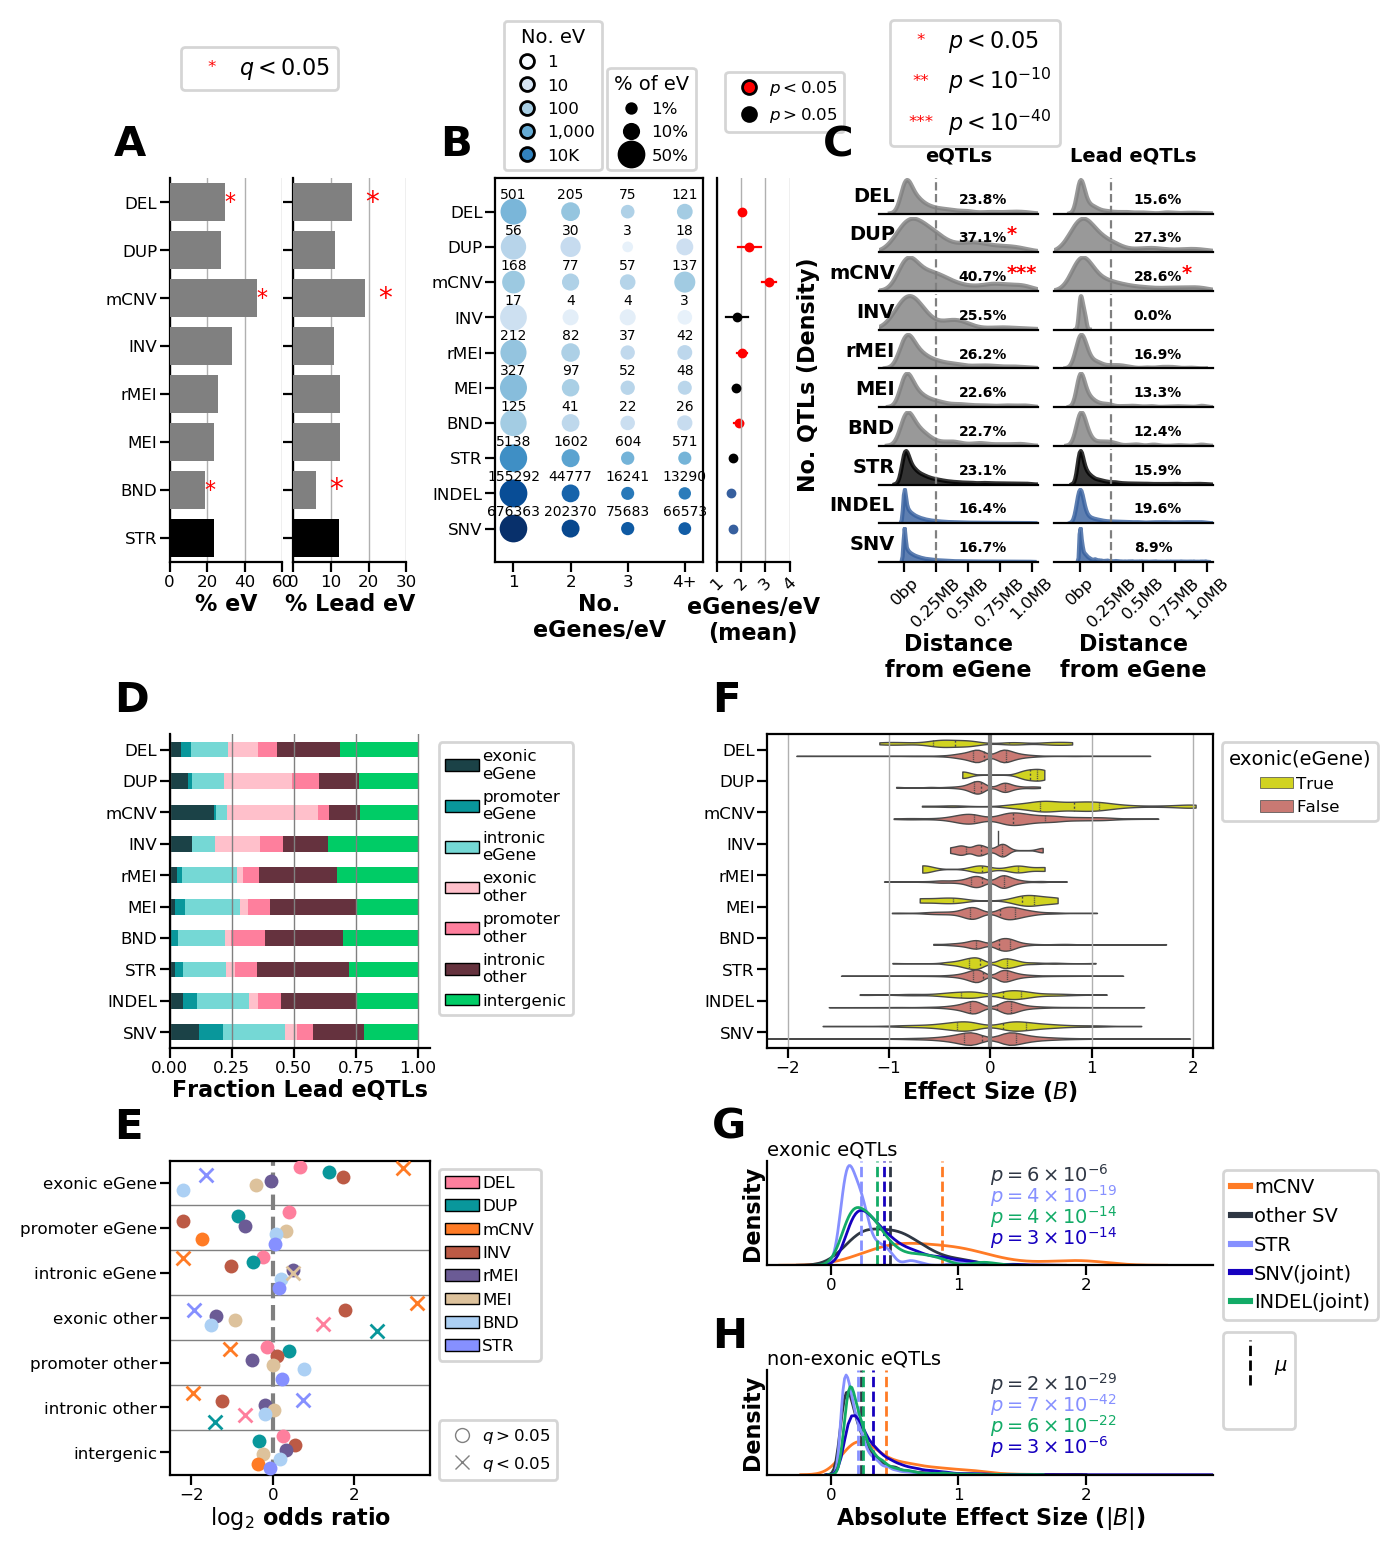

In [291]:
fig =plt.figure(figsize=(7,9), dpi = 200)
gs = mpl.gridspec.GridSpec(6, 6, 
                           figure =fig, height_ratios = [0.8, 0.8, 1, 1, 1, 1], wspace = 0.9,
                           hspace=1.2)

subgrid2 = mpl.gridspec.GridSpecFromSubplotSpec(2,5, subplot_spec=gs[0:2,:], wspace=0.65,
                                               hspace= 0.35, width_ratios = [0.15, 0.15, 0.6, 0.3, 0.2])
# ax1 = fig.add_subplot(gs[0:2,:])



subgrid_bp = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=subgrid2[:, :2], wspace=0.1,
                                               hspace= 0.1, width_ratios = [1,1])
subgrid_bp2 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=subgrid2[:, 2], wspace=0.1,
                                               hspace= 0.1, width_ratios = [1,0.35])

subgrid_bp3 = mpl.gridspec.GridSpecFromSubplotSpec(10,2, subplot_spec= subgrid2[:, 3:], wspace=0.1,
                                               hspace= 0.1, width_ratios = [1,1])

ax1 = fig.add_subplot(subgrid_bp[0])
ax2 = fig.add_subplot(subgrid_bp[1])
# ax3 = fig.add_subplot(subgrid_bp[2])
# ax3 = fig.add_subplot(subgrid2[:, 1])

# ax4 = fig.add_subplot(subgrid2[:, 2])
ax4_a = fig.add_subplot(subgrid_bp2[0])
ax4_b = fig.add_subplot(subgrid_bp2[1])
# ax4_b.set_title('here')



subgrid_bb = mpl.gridspec.GridSpecFromSubplotSpec(8,1, subplot_spec=subgrid2[:, 3], wspace=0.3,
                                               hspace= 0.1, width_ratios = [1])



# ax5 =  fig.add_subplot(subgrid2[:,-1])


subgrid3 = mpl.gridspec.GridSpecFromSubplotSpec(6,5, subplot_spec=gs[2:5,:], width_ratios=[2.5, 0.15, 0.15, 
                                                                                           0.8,
                                                                                           2.5],
                                                height_ratios = [1,1,1,1, 1, 1],
                                                wspace=0.8,
                                               hspace=3.8)

sg8 =  mpl.gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=subgrid3[3:,3:], 
                                            width_ratios=[1, 1],
                                            wspace=0, hspace= 1)



ax6 = fig.add_subplot(subgrid3[:3,:1])
# ax6_leg = fig.add_subplot(subgrid3[:4,0])
ax7 = fig.add_subplot(subgrid3[3:,:1])

ax8 = fig.add_subplot(subgrid3[:3,3:])

# ax8_a = fig.add_subplot(sg8[0,0])
# ax8_b = fig.add_subplot(sg8[1,0])
# ax8_c = fig.add_subplot(sg8[0,1])
# ax8_d = fig.add_subplot(sg8[1,1])
# ax8_d.set_title('ax8D')



ax8_b = fig.add_subplot(sg8[0,:])
ax8_c = fig.add_subplot(sg8[1,:])



########################################### BARGRAPHS PERCENT TESTED THAT ARE EVARIANTS (all)
xticks = [0, 0.2, 0.4, 0.6]
ax1.xaxis.grid(zorder = 0)

ax1 = sns.barplot(x = 'fraction', y = 'SVTYPE_NR_C', palette = color_pal_vs_str,
                  data = frac_svtype_all,
                  order = order_vars_c, ax = ax1, zorder = 20)

p_vals = enr_svtypes_nr_c.set_index('SVTYPE_NR_C').loc[order_vars_c].fdr_corrected_p.tolist()
p_vals[-1] = 1
# annotate_bars(ax1, orient = 'h', xytext=(5,-5), list_of_vals=p_vals, fmt_sci=True, use_split_fmts=True,
#              color_split = False,color = 'black', use_mid = True, color_high = 'white', color_low = 'red',
#              fmt = '$p = {:.2f}$', sci_fmt = "$p = {0:s}$", weight = 'bold', fontsize = 5)

annotate_bars(ax1, orient = 'h', xytext=(0,0), list_of_vals=p_vals, fmt_sci=True, use_split_fmts=True,
             color_split = True, use_mid =False, color_high = 'white', color_low = 'red', specific_label= '*', 
             label_below = 0.05)

ax1.set_xticks(xticks)
ax1.set_ylabel('')
sns.despine(ax = ax1)

# ax1.set_title('eVariant', color =  color_pal_lead_sig['significant'])
ax1.set_xlabel('% eV')
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=0))
############################################ BARGRAPHS PERCENT TESTED THAT ARE EVARIANTS (lead)
xticks = [0, 0.1, 0.2, 0.3]

ax2.xaxis.grid(zorder = 0)
ax2 = sns.barplot(x = 'fraction', y = 'SVTYPE_NR_C', 
                  data = frac_svtype_th, palette= color_pal_vs_str,
                  order = order_vars_c, ax = ax2, label = 'lead', zorder = 20)

p_vals = enr_svtypes_th_c.set_index('SVTYPE_NR_C').loc[order_vars_c].fdr_corrected_p.tolist()
p_vals[-1] = 1

# annotate_bars(ax2, orient = 'h', xytext=(5,-5), list_of_vals=p_vals, fmt_sci=True, use_split_fmts=True,
#              color_split = False,color = 'black', use_mid = True, color_high = 'white', color_low = 'red',
#              fmt = '$p = {:.2f}$', sci_fmt = "$p = {0:s}$", weight = 'bold', fontsize = 5)

annotate_bars(ax2, orient = 'h', xytext=(5,0), list_of_vals=p_vals, fmt_sci=True, use_split_fmts=True,
             color_split = True, use_mid =False, color_high = 'white', color_low = 'red', specific_label= '*', 
             label_below = 0.05, fontsize = 10)

ax2.set_yticklabels([])
ax2.set_ylabel('')
ax2.set_xlim(0, 0.25)
ax2.set_xticks(xticks)
sns.despine(ax = ax2)
ax2.set_xlabel('% Lead eV')
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=0))



########################################## BALLOON PLOT AND MEAN #################################

ax = ax4_a

sns.scatterplot(x = 'cap_num_egenes', y = 'SVTYPE_rank', size = 'sizes', hue = 'num_ev', data = fpc_all_plot,
                sizes = (15, 100), ax = ax, hue_norm=mpl.colors.LogNorm(vmin = 1), 
                palette=mpl.cm.Blues, linewidth = 0, 
                edgecolor = 'black', zorder = 25, legend = False)

for i, x in fpc_all_plot.iterrows():
    xc = x['cap_num_egenes']
    yc = x['SVTYPE_rank']
    tall = x['num_ev']
    
#     print xc, yc, tall
    ax.annotate(s = tall, xy = (xc, yc),  xytext = (0,6), textcoords = 'offset points', 
                color = 'black', fontsize = 5, zorder = 50, ha = 'center', va = 'center')

ymin, ymax = ax.get_ylim()
ytls = sorted(fpc_all_plot.SVTYPE_rank.unique())
xticks =  sorted(fpc_all_plot.cap_num_egenes.unique())
buff = (ymax-ymin) * 0.05
print buff, ymin, ymax
ax.set_yticklabels(list(reversed(order_vars_c_all)))
ax.set_ylim(ymin - buff, ymax + abs(buff))
ax.set_yticks(ytls)
xmin, xmax = ax.get_xlim()
buff = (xmax-xmin) * 0.05
ax.set_xlim(xmin - buff, xmax + buff)
# ax4.set_yticklabels([""] + list(reversed(order_vars_c)))
xtls = ['1', '2', '3', '4+']
ax.set_xticks(xticks)
ax.set_xticklabels(xtls)

# ax.set_yticklabels([])
ax.set_ylabel('')


norm = mpl.colors.LogNorm(vmin = 1, vmax = fpc_all_plot.num_ev.max())
n = [1,10, 100, 1000, 10000]
colors = []
for i in n:
    rgba = mpl.cm.Blues(norm(i))
    c = mpl.colors.rgb2hex(rgba)
    colors.append(c)

labs = ["{:,}".format(i) for i in n]
labs[-1] = '10K'
patches = mpltools.get_legend_patches(labs, markerfacecolor=colors, 
                                      markersize=5)
leg = ax.legend(handles = patches, 
                bbox_to_anchor = (0,1), loc = 'lower left', ncol = 1,
                fontsize = 6, title = 'No. eV')
ax.add_artist(leg)

sizes_all = fpc_all_plot.sizes.values.reshape(-1, 1)

sizes_leg = [0.01, 0.1, 0.5]
sizes = (np.log10((np.array(sizes_leg) + 1)) * 100).reshape(-1,1)
# sizes_all = fpc.sizes.values
scaler = MinMaxScaler(feature_range=(15,100))
scaler.fit(sizes_all)
s = scaler.transform(sizes).reshape(-1)
s = np.sqrt(s) # remember to add an arg to my patch function that will sqrt the sizes if trying to match a scatter
labels = ["{:.0%}".format(i) for i in sizes_leg]


patches = mpltools.get_legend_patches(labels, markerfacecolor='black', markersize=s)
leg = ax.legend(handles = patches, bbox_to_anchor = (0.5,1), loc = 'lower left', ncol =1, fontsize = 6,
               title = '% of eV')
ax.set_xlabel('No.\neGenes/eV')
gs.tight_layout(fig)



########################################## Mean eGenes/eVar ############################################
color_pal_sig_enr = {True: 'red', False :'black'}
stats_es_svt_ne['significant'] = ((stats_es_svt_ne.p_bonf < 0.05) & (stats_es_svt_ne.SVTYPE_NR_C != 'STR'))
stats_es_svt_ne['color'] = stats_es_svt_ne['significant'].map(color_pal_sig_enr)
color_pal = stats_es_svt_ne.color.to_dict()
color_pal['SNV'] = '#365f9e'
color_pal['INDEL'] = '#365f9e'

ax4_b.xaxis.grid(zorder = 0)
sns.pointplot(y = 'SVTYPE_NR_C', x = 'num_egenes', data = per_var_combined[per_var_combined.num_egenes > 0], hue ='SVTYPE_NR_C', 
              palette = color_pal, order = order_vars_c_all, ax = ax4_b, 
              join = False, scale = 0.4,errwidth = 0.8, zorder = 20)


ax4_b.legend().remove()
ax4_b.set_ylabel('')
ax4_b.set_yticklabels([])
ax4_b.set_xticks([1, 2,  3, 4])
ax4_b.tick_params(axis = 'x', labelrotation = 45)


colors = ['red', 'black']
labels = ['$p < 0.05$', '$p > 0.05$']
patches = mpltools.get_legend_patches(labels, markerfacecolor=colors, markersize=5)

leg = ax4_b.legend(handles = patches, bbox_to_anchor = (0,1.1), loc = 'lower left', ncol =1, fontsize = 6,
               title = '')

ax4_b.tick_params(axis = 'y', length = 0)
sns.despine(ax = ax4_b)
ax4_b.set_xlabel('eGenes/eV\n(mean)')
ax4_b.set_ylim(list(reversed(ax4_a.get_ylim())))

##########################DISTRIBUTION OF eQTLs #############################################
### Plot QTL Dist
##### ALL significant
xticks = np.arange(0, 1050000, 250000)
axes = []
axes2 = []
for i, svt in enumerate(order_vars_c_all):
    a = fig.add_subplot(subgrid_bp3[i: i+1, 0], facecolor = (0,0,0,0))
    a2 = fig.add_subplot(subgrid_bp3[i: i+1, 1], facecolor = (0,0,0,0))
    axes.append(a)
    axes2.append(a2)
    if svt not in ['SNV', 'INDEL']:

        tdf = var_egene[(var_egene.SVTYPE_NR_C == svt) & (var_egene_nr.significant)]
        c =  sns.kdeplot(tdf['gene_distance'].abs(),ax = a, color = color_pal_vs_str[svt],
                            label = svt, legend = False, shade = True, alpha = 0.8)
        tdf = var_egene[(var_egene.SVTYPE_NR_C == svt) & (var_egene_nr.top_hit_final_sig)]
        c =  sns.kdeplot(tdf['gene_distance'].abs(),ax = a2, color =  color_pal_vs_str[svt],
                            label = svt, legend = False, shade = True, alpha = 0.8)
        
    else:
        tdf = sig_joint[(sig_joint.VARIANT_TYPE == svt)]
        c =  sns.kdeplot(tdf['gene_distance'].abs(),ax = a, color = color_pal_vs_str[svt],
                            label = svt, legend = False, shade = True, alpha = 0.8)
        tdf = th_joint[(th_joint.VARIANT_TYPE == svt)]
        c =  sns.kdeplot(tdf['gene_distance'].abs(),ax = a2, color =  color_pal_vs_str[svt],
                            label = svt, legend = False, shade = True, alpha = 0.8, )

    for ax in [a, a2]:
        ax.set_yticklabels([])
        ax.set_xlim(-200000, 1050000)
        ax.set_xticks(xticks)
        ax.set_xticklabels(mpltools.format_base_pair_scale(xticks))
        sns.despine(ax =ax, left = True)
        if svt != 'SNV':
            ax.set_xticklabels([])
            ax.tick_params(axis = 'x', length = 0)
        ax.tick_params(axis = 'y', length = 0)
        ax.axvline(x = 250000, ymin=0, ymax = 1, linestyle = '--', lw = 0.8, color = 'grey')
        
    
    if svt not in ['SNV', 'INDEL']:
        frac = "{:0.1%}".format(frac_250kb_qtl_all.loc[svt, 'fraction'])
        a.text(x = 0.5, y = 0.4, s =frac, transform = a.transAxes, fontsize = 5, ha = 'left', va = 'center',
              color = 'black', weight = 'bold')

        pv = stats_gd_sig.loc[svt, 'p_bonf']
        if pv < 1e-40:
            a.text(x = 0.8, y = 0.5, s = "***", transform = a.transAxes, ha = 'left', 
                   va = 'center', fontsize= 7, weight = 'bold', color = 'red')
        else:
            if pv < 0.05:
                 a.text(x = 0.8, y = 0.5, s = "*", transform = a.transAxes, 
                        ha = 'left', va = 'center', fontsize= 7, weight = 'bold', color = 'red')


        pv2 = stats_gd_lead.loc[svt, 'p_bonf']
        if pv2 < 1e-40:
            a2.text(x = 0.8, y = 0.5, s = "***", transform = a2.transAxes, ha = 'left', 
                   va = 'center', fontsize= 7, weight = 'bold', color = 'red')
        else:
            if pv2 < 0.05:
                 a2.text(x = 0.8, y = 0.5, s = "*", transform = a2.transAxes, 
                        ha = 'left', va = 'center', fontsize= 7, weight = 'bold', color = 'red')

        frac = "{:0.1%}".format(frac_250kb_qtl_th.loc[svt, 'fraction'])
        a2.text(x = 0.5, y = 0.4, s =frac, transform = a2.transAxes, fontsize = 5, ha = 'left', va = 'center',
              color = 'black', weight = 'bold')

        a.text(x = 0.1, y = 0.5, s = svt, transform = a.transAxes, ha = 'right', va = 'center',
               color =  'black', fontsize= 7, weight = 'bold')
    else:
        
        frac = "{:0.1%}".format(frac_250kb_snv_indel.loc[svt, 'fraction'])
        a.text(x = 0.5, y = 0.4, s =frac, transform = a.transAxes, fontsize = 5, ha = 'left', va = 'center',
              color = 'black', weight = 'bold')
        frac = "{:0.1%}".format(frac_250kb_snv_indel_th.loc[svt, 'fraction'])
        a2.text(x = 0.5, y = 0.4, s =frac, transform = a2.transAxes, fontsize = 5, ha = 'left', va = 'center',
              color = 'black', weight = 'bold')

        a.text(x = 0.1, y = 0.5, s = svt, transform = a.transAxes, ha = 'right', va = 'center',
               color =  'black', fontsize= 7, weight = 'bold')
    
        
axes[4].set_ylabel('No. QTLs (Density)      \n\n')
for axf in [axes, axes2]:

    axf[-1].set_xlabel('Distance\nfrom eGene')
    axf[-1].tick_params(axis = 'x', labelrotation = 45)

ax5_a = axes[0]
ax5_b = axes2[0]

ax5_a.set_title('eQTLs',fontsize = 7, weight = 'bold')
ax5_b.set_title('Lead eQTLs', fontsize = 7, weight = 'bold')



########################### GENIC OVERLAP ######################

ax6.xaxis.grid(zorder = 0, linewidth = 0.5, color = 'grey')
sb_gen_cat_plot.loc[order_vars_c_all, order_genic_cats_full].plot(kind = 'barh', stacked = True, color = [pal_genic_cats_full[i] for i in order_genic_cats_full], ax = ax6)
ax6.invert_yaxis()
ax6.xaxis.grid()
sns.despine(ax = ax6)
ax6.set_xlabel('Fraction Lead eQTLs')
ax6.set_ylabel('')

leg6 = ax6.legend(bbox_to_anchor = (0,0), loc = 'lower left', ncol = 2, 
           fontsize = 6)


### Enrichment plot for the SV only #### 

tdf = enr_svt_genic_cat_lead_prop
tdf['significant'] = tdf.fdr_corrected_p < 0.05
# tdf = chmm15_pv_nr[(chmm15_pv_nr.log2_odds_ratio_raw < 10) & (chmm15_pv_nr.log2_odds_ratio_raw > -10)]
tdf1 = tdf[tdf.significant == False]
tdf2 = tdf[tdf.significant]


sns.stripplot(y = 'category', x = 'log2_odds_ratio', hue = 'SVTYPE', 
              data = tdf1, dodge = True, palette=color_pal_svtypes_all.to_dict(), edgecolor = 'black', 
              order = order_genic_cats_full, jitter = True, ax = ax7)

sns.stripplot(y = 'category', x = 'log2_odds_ratio', hue = 'SVTYPE', order = order_genic_cats_full,
              data = tdf2 , palette=color_pal_svtypes_all.to_dict(), lw = 1, s= 5,  color = 'black', 
              marker = 'x',dodge=True, jitter = True, ax = ax7)

ax7.legend().set_visible(False)


ylim = ax7.get_ylim()
max_y = max(ylim)
min_y = min(ylim)
t = np.arange(min_y, max_y, 1)[1:]
for l in t:
    ax7.axhline(l, color = 'grey', lw = 0.5)

ax7.axvline(0, linestyle = '--', color = 'grey')
ax7.legend(bbox_to_anchor = (1,1), loc = 'upper left').set_visible(False)
ax7.set_ylabel('')
ax7.set_xlabel('$\log_{2}$ odds ratio')
ytls = [i.get_text().replace('_', ' ') for i in ax7.get_yticklabels()]
ax7.set_yticklabels(ytls)



######################### EFFECT SIZE ############################
ax8.xaxis.grid(zorder = 0)
color_pal = {True:'#eef102', False : '#d76c65'}
sns.violinplot(y= 'SVTYPE_NR_C', x = 'beta_corrected', data = th_all,
               order= order_vars_c_all, 
               hue = 'exonic', hue_order = [True, False], ax = ax8, linewidth = 0.5,
               inner='quartile',
               palette = color_pal, bw = 0.2,
              cut = 0)
ax8.set_ylabel('')
ax8.axvline(0, linestyle = '-', color = 'grey')
ax8.set_xticks([-2,-1, 0,1,2])
ax8.set_xlabel('Effect Size ($B$)')
ax8.set_xlim(-2.2, 2.2)





####################### EFFECT SIZE ABSOLUTE ##########################

top = var_egene_nr[(var_egene_nr.top_hit_final_sig) & (var_egene_nr.coding)]
tdf = stats_mcnv_abs_es[(stats_mcnv_abs_es.category == 'exonic')].set_index('versus')

xticks = [0,1,2]
lwa = 1
ax = ax8_b
svt = 'mCNV'
obs = top[top.SVTYPE_NR_C == 'mCNV'].beta_abs
print obs.shape, comp.shape
sns.kdeplot(obs, ax = ax, color = color_pal_svtypes_all[svt],
                        label = svt, legend = False, shade = False, lw = lwa)
ax.axvline(obs.mean(), linestyle = '--', color = color_pal_svtypes_all['mCNV'], lw = lwa)


comp = top[~(top.SVTYPE_NR_C.isin(['STR', svt]))].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['CNV'],
                        label = 'other SV', legend = False, shade = False, lw = lwa)

ax.axvline(comp.mean(), linestyle = '--', color = color_pal_svtypes_all['CNV'], lw = lwa)


comp = top[top.SVTYPE_NR_C == 'STR'].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['STR'],
                        label = 'STR', legend = False, shade = False, lw = lwa)

ax.axvline(comp.mean(), linestyle = '--', color = color_pal_svtypes_all['STR'], lw = lwa)


comp = th_joint[(th_joint.VARIANT_TYPE.isin(['SNV'])) &
                (th_joint.exonic)].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['SNV'],
                        label = 'SNV(joint)', legend = False, shade = False, lw = lwa)
ax.axvline(comp.mean(), linestyle = '--', 
           color = color_pal_svtypes_all['SNV'], lw = lwa)

comp = th_joint[(th_joint.VARIANT_TYPE.isin(['INDEL'])) & 
                (th_joint.exonic)].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['INDEL'],
                        label = 'INDEL(joint)', legend = False, shade = False, lw = lwa)
ax.axvline(comp.mean(), linestyle = '--', 
           color = color_pal_svtypes_all['INDEL'], lw = lwa)

leg = ax.legend(bbox_to_anchor= (1,1), loc = 'upper left', ncol = 1, handlelength = 1)
for line in leg.get_lines():
    line.set_linewidth(2.2)


p_sv = tdf.loc['SV', 'p_bonf']
p_str = tdf.loc['STR', 'p_bonf']


ax.text(0.5, 0.8, "$p={}$".format(as_si(p_sv, 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['CNV'])

ax.text(0.5, 0.6, "$p={}$".format(as_si(p_str, 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['STR'])

ax.text(0.5, 0.4, "$p={}$".format(as_si(tdf.loc['INDEL', 'p_bonf'], 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['INDEL'])


ax.text(0.5, 0.2, "$p={}$".format(as_si(tdf.loc['SNV', 'p_bonf'], 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['SNV'])


#################### non-exonic ##########

top = var_egene_nr[(var_egene_nr.top_hit_final_sig) & (var_egene_nr.coding == False)]
tdf = stats_mcnv_abs_es[(stats_mcnv_abs_es.category == 'non-exonic')].set_index('versus')

xticks = [0,1,2]
lwa = 1
ax = ax8_c
svt = 'mCNV'
obs = top[top.SVTYPE_NR_C == 'mCNV'].beta_abs
print obs.shape, comp.shape
sns.kdeplot(obs, ax = ax, color = color_pal_svtypes_all[svt],
                        label = '__nolegend__', legend = False, shade = False, lw = lwa)
ax.axvline(obs.mean(), linestyle = '--', color = color_pal_svtypes_all['mCNV'], 
           lw = lwa, label = '__nolegend__')


comp = top[~(top.SVTYPE_NR_C.isin(['STR', svt]))].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['CNV'],
                        label = '__nolegend__', legend = False, shade = False, lw = lwa)

ax.axvline(comp.mean(), linestyle = '--', color = color_pal_svtypes_all['CNV'], 
           lw = lwa, label = '__nolegend__')


comp = top[top.SVTYPE_NR_C == 'STR'].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['STR'],
                        label = '__nolegend__', legend = False, shade = False, lw = lwa)

ax.axvline(comp.mean(), linestyle = '--',
           color = color_pal_svtypes_all['STR'], lw = lwa, label = '__nolegend__')


comp = th_joint[(th_joint.VARIANT_TYPE.isin(['SNV'])) &
                (th_joint.exonic == False)].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['SNV'],
                        label = '__nolegend__', legend = False, shade = False, lw = lwa)
ax.axvline(comp.mean(), linestyle = '--', 
           color = color_pal_svtypes_all['SNV'], lw = lwa, label = '__nolegend__')

comp = th_joint[(th_joint.VARIANT_TYPE.isin(['INDEL'])) & 
                (th_joint.exonic == False)].beta_abs
sns.kdeplot(comp, ax = ax, color = color_pal_svtypes_all['INDEL'],
                        label = '__nolegend__', legend = False, shade = False, lw = lwa)
ax.axvline(comp.mean(), linestyle = '--', 
           color = color_pal_svtypes_all['INDEL'], lw = lwa, label = '__nolegend__')

ax.axvline(-2, linestyle = '--', color = 'black', lw = lwa, label = "$\mu$\n")
leg = ax.legend(handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)}, handleheight = 6, 
                bbox_to_anchor = (1,0.9), loc = 'center left')

p_sv = tdf.loc['SV', 'p_bonf']
p_str = tdf.loc['STR', 'p_bonf']


ax.text(0.5, 0.8, "$p={}$".format(as_si(p_sv, 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['CNV'])

ax.text(0.5, 0.6, "$p={}$".format(as_si(p_str, 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['STR'])

ax.text(0.5, 0.4, "$p={}$".format(as_si(tdf.loc['INDEL', 'p_bonf'], 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['INDEL'])


ax.text(0.5, 0.2, "$p={}$".format(as_si(tdf.loc['SNV', 'p_bonf'], 0)), 
        transform = ax.transAxes, ha = 'left', 
       color = color_pal_svtypes_all['SNV'])




ax8_c.set_xlabel('Absolute Effect Size ($|B|$)')
for a in [ax8_b, ax8_c]:
    a.set_xticks(xticks)
    sns.despine(ax = a)
    a.set_yticks([])
    a.set_yticklabels([])
    a.set_xlim(-0.5,3)
    a.set_ylabel('Density')

ax8_b.set_title('exonic eQTLs', fontsize = 7, pad = 2, loc = 'left')
ax8_c.set_title('non-exonic eQTLs', fontsize = 7, pad = 2, loc='left')
gs.tight_layout(fig, h_pad= 2.5)





############################# Additional Legend Work ##############
markers = ['o', 'x']
ec  = ['grey', 'grey']
labels = ['$q > 0.05$', '$q < 0.05$']

patches = mpltools.get_legend_patches(labels, 
                                      marker=markers,
                                      markeredgecolor='grey',
                                      markeredgewidth=0.5,
                                      markersize = 5)


leg = ax7.legend(handles = patches, bbox_to_anchor = [1,0.2], loc = 'upper left', ncol = 1, fontsize = 6)
ax7.add_artist(leg)

labels_for_leg = [ '*', '**', '***']
p_val_labs = ['$ p < 0.05$',r'$p < 10^{-10}$', r'$p < 10^{-40}$']
leg_ax = fig.add_subplot(gs[0,0])
handles, labels, handler_map = get_text_handles_for_legend(leg_ax, labels_for_leg, p_val_labs, size = 6,
                               color = 'red', x= -1, y = -1)
legend = ax5_a.legend(handles, p_val_labs, handler_map=handler_map, bbox_to_anchor = [0,1.6], loc = 'lower left',
                   fontsize = 8, ncol = 1 ) 

leg_ax.remove()


labels_for_leg = [ '*']
p_val_labs = ['$ q < 0.05$']
leg_ax = fig.add_subplot(gs[0,0])
handles, labels, handler_map = get_text_handles_for_legend(leg_ax, labels_for_leg, p_val_labs, size = 6,
                               color = 'red', x= -1, y = -1)
legend = ax1.legend(handles, p_val_labs, handler_map=handler_map, bbox_to_anchor = [0,1.2], loc = 'lower left',
                   fontsize = 8, ncol = 1 ) 

leg_ax.remove()




labels =  order_vars_c
markerc = [color_pal_svtypes_all[i] for i in labels]
patches = mpltools.get_legend_patches(labels, just_rect=True, rectfacecolor=markerc, rectedgecolor='black',
                                      rectlinewidth=0.5)

leg3 = ax7.legend(handles = patches, bbox_to_anchor = [1, 1], loc = 'upper left', 
                   ncol = 1, fontsize = 6)

# leg3 = ax9.legend(handles = patches, bbox_to_anchor = [1, 1], loc = 'upper left', 
#                    ncol = 1, fontsize = 6)



labels = [i.replace('_', '\n') for i in order_genic_cats_full]
colors = [pal_genic_cats_full[i] for i in order_genic_cats_full]
patches = mpltools.get_legend_patches(labels, just_rect=True, rectfacecolor=colors, rectedgecolor='black',
                                      rectlinewidth=0.5)
ax6.legend(handles = patches, bbox_to_anchor = [1, 1], loc = 'upper left', 
                   ncol = 1, fontsize = 6)

ax8.legend(bbox_to_anchor = [1, 1], loc = 'upper left', 
                   ncol = 1, fontsize = 6, title = 'exonic(eGene)')


labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
for i, a in enumerate([ax1, ax4_a, ax5_a, ax6, ax7, ax8, ax8_b, ax8_c]):
    mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 8)


out_fn = figures_out + '/Figure_Characteristics_SV_eQTLs_v7'
fig.savefig(out_fn, bbox_inches='tight', dpi = 500)